In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [2]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [3]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [13]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [17]:
def run():
    chi_list = np.arange(16, 50, 2)

    model_params = dict(conserve=None, Jx=1., Jy=1., Jz=1., L=24, verbose=1)
    prod_state = ["up", "down"] * (2 * model_params['L'])
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
        'mixer': True,  # setting this to True helps to escape local minima
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'svd_min': 1.e-10,
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-6,
        'max_sweeps': 150,
        'verbose': 1.,
    }
    
    print("=" * 100)
    
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    data = dict(entropy_list=[], correlation_list=[])
    for chi in chi_list:
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        eng.run()
        eng.engine_params['mixer'] = None
        psi.canonical_form()
        
        entropy = np.mean(psi.entanglement_entropy())
        correlation = psi.correlation_length()

        data['entropy_list'].append(entropy)
        data['correlation_list'].append(correlation)
        tenpy.tools.optimization.optimize(3)
        pass
        
    return data


def plot_results(data):

    plt.figure()
    ax = plt.gca()
    ax.plot(data['ent_spectrum'], marker='o')
    ax.set_xlabel(r"DMRG Step")
    ax.set_ylabel(r"$ E $")
    plt.savefig("KitaevLadderModel.pdf")


In [18]:
data = run()
# plot_results(data)
print(data)

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=24 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=1.0 for KitaevLadderModel
parameter 'Jy'=1.0 for KitaevLadderModel
parameter 'Jz'=1.0 for KitaevLadderModel
parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'svd_min': 1e-10} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
Initial sweeps...
Updating environment
..........
parameter 'max_sweeps'=150 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-06 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:124: UserWarning: unused parameters for Sweep mixer_params:
['amplitude', 'decay', 'disable_after']
  warnings.warn(msg.format(keys=sorted(unused), descr=warn))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:124: UserWarning: unused parameters for Sweep:
['max_E_err', 'max_S_err', 'max_sweeps', 'mixer', 'mixer_params']
  warnings.warn(msg.format(keys=sorted(unused), descr=warn))


Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097005531048796, S = nan, norm_err = 5.6e-08
Current memory usage 192.2 MB, time elapsed: 56.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5800e-06, max_E_trunc = 1.3231e-06
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097005512694992, S = nan, norm_err = 9.1e-09
Current memory usage 192.2 MB, time elapsed: 98.1 s
Delta E = 1.8354e-10, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5765e-06, max_E_trunc = 1.3290e-06
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2018: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2168: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464072622, S = 0.5300859889637907, norm_err = 2.2e-14
Current memory usage 192.9 MB, time elapsed: 24.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.4552e-11, max_E_trunc = 1.4938e-10
MPS bond dimensions: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464117706, S = 0.5300859972845410, norm_err = 1.8e-14
Current memory usage 192.9 MB, time elapsed: 49.7 s
Delta E = -4.5084e-13, Delta S = 8.3208e-10 (per sweep)
max_trunc_err = 7.8151e-11, max_E_trunc = 1.3779

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464806305, S = 0.5300860483119961, norm_err = 1.2e-14
Current memory usage 192.9 MB, time elapsed: 26.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.5386e-12, max_E_trunc = 6.9349e-12
MPS bond dimensions: [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464805867, S = 0.5300860482885533, norm_err = 8.7e-15
Current memory usage 192.9 MB, time elapsed: 55.2 s
Delta E = 4.3826e-15, Delta S = -2.3443e-12 (per sweep)
max_trunc_err = 1.5389e-12, max_E_trunc = 8.6402

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464818858, S = 0.5300860491012593, norm_err = 2.4e-14
Current memory usage 192.9 MB, time elapsed: 27.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.7781e-13, max_E_trunc = 4.7748e-12
MPS bond dimensions: [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464818704, S = 0.5300860491013643, norm_err = 1.5e-14
Current memory usage 192.9 MB, time elapsed: 56.1 s
Delta E = 1.5404e-15, Delta S = 1.0492e-14 (per sweep)
max_trunc_err = 7.7781e-13, max_E_trunc = 5.2296e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464826573, S = 0.5300860499489964, norm_err = 2.2e-14
Current memory usage 192.9 MB, time elapsed: 29.2 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.8482e-14, max_E_trunc = 2.7285e-12
MPS bond dimensions: [28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464825845, S = 0.5300860499543165, norm_err = 1.9e-14
Current memory usage 192.9 MB, time elapsed: 58.7 s
Delta E = 7.2831e-15, Delta S = 5.3201e-13 (per sweep)
max_trunc_err = 3.9891e-14, max_E_trunc = 5.4570e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464827307, S = 0.5300860499716326, norm_err = 2.3e-14
Current memory usage 192.9 MB, time elapsed: 31.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1176e-14, max_E_trunc = 3.1832e-12
MPS bond dimensions: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464824365, S = 0.5300860499716772, norm_err = 1.7e-14
Current memory usage 192.9 MB, time elapsed: 61.3 s
Delta E = 2.9426e-14, Delta S = 4.4631e-15 (per sweep)
max_trunc_err = 3.1176e-14, max_E_trunc = 7.0486e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464827266, S = 0.5300860499876968, norm_err = 2.3e-14
Current memory usage 193.4 MB, time elapsed: 29.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.2739e-14, max_E_trunc = 2.7285e-12
MPS bond dimensions: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464827657, S = 0.5300860499877036, norm_err = 1.7e-14
Current memory usage 193.4 MB, time elapsed: 59.1 s
Delta E = -3.9080e-15, Delta S = 6.7724e-16 (per sweep)
max_trunc_err = 2.2739e-14, max_E_trunc = 4.5475

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464827041, S = 0.5300860499994163, norm_err = 2.0e-14
Current memory usage 193.4 MB, time elapsed: 31.8 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.5060e-14, max_E_trunc = 2.8422e-12
MPS bond dimensions: [34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464825833, S = 0.5300860499993766, norm_err = 1.6e-14
Current memory usage 193.4 MB, time elapsed: 62.8 s
Delta E = 1.2079e-14, Delta S = -3.9746e-15 (per sweep)
max_trunc_err = 1.5060e-14, max_E_trunc = 4.3201

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464827396, S = 0.5300860500096327, norm_err = 2.1e-14
Current memory usage 199.7 MB, time elapsed: 30.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.7495e-15, max_E_trunc = 2.7285e-12
MPS bond dimensions: [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464826828, S = 0.5300860500111958, norm_err = 1.8e-14
Current memory usage 199.7 MB, time elapsed: 65.2 s
Delta E = 5.6843e-15, Delta S = 1.5631e-13 (per sweep)
max_trunc_err = 7.7757e-15, max_E_trunc = 3.6380e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464828497, S = 0.5300860500234517, norm_err = 2.4e-14
Current memory usage 205.9 MB, time elapsed: 31.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 4.6957e-16, max_E_trunc = 2.3874e-12
MPS bond dimensions: [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464827645, S = 0.5300860500234841, norm_err = 1.8e-14
Current memory usage 205.9 MB, time elapsed: 63.7 s
Delta E = 8.5265e-15, Delta S = 3.2419e-15 (per sweep)
max_trunc_err = 4.8457e-16, max_E_trunc = 3.8654e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464827817, S = 0.5300860500237053, norm_err = 2.1e-14
Current memory usage 207.8 MB, time elapsed: 33.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.9899e-16, max_E_trunc = 2.1600e-12
MPS bond dimensions: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 40, 40, 40, 40, 40, 39, 40, 40, 40, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464827289, S = 0.5300860500236476, norm_err = 2.0e-14
Current memory usage 207.8 MB, time elapsed: 65.9 s
Delta E = 5.2708e-15, Delta S = -5.7732e-15 (per sweep)
max_trunc_err = 3.9577e-16, max_E_trunc = 3.1832

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464826390, S = 0.5300860500239500, norm_err = 2.0e-14
Current memory usage 207.8 MB, time elapsed: 34.6 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 3.1054e-16, max_E_trunc = 1.7053e-12
MPS bond dimensions: [41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42, 41, 42]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464827822, S = 0.5300860500239307, norm_err = 1.8e-14
Current memory usage 207.8 MB, time elapsed: 71.5 s
Delta E = -1.4327e-14, Delta S = -1.9318e-15 (per sweep)
max_trunc_err = 3.1048e-16, max_E_trunc = 3.865

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464826946, S = 0.5300860500242325, norm_err = 2.4e-14
Current memory usage 207.8 MB, time elapsed: 37.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 2.2850e-16, max_E_trunc = 1.5916e-12
MPS bond dimensions: [42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44, 42, 44]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464827112, S = 0.5300860500242438, norm_err = 1.8e-14
Current memory usage 207.8 MB, time elapsed: 74.3 s
Delta E = -1.6570e-15, Delta S = 1.1324e-15 (per sweep)
max_trunc_err = 2.2850e-16, max_E_trunc = 3.4106

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464827532, S = 0.5300860500243563, norm_err = 1.9e-14
Current memory usage 220.1 MB, time elapsed: 36.9 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.5166e-16, max_E_trunc = 2.3874e-12
MPS bond dimensions: [44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46, 44, 46]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464827408, S = 0.5300860500243357, norm_err = 1.7e-14
Current memory usage 220.1 MB, time elapsed: 73.2 s
Delta E = 1.2434e-15, Delta S = -2.0539e-15 (per sweep)
max_trunc_err = 1.5166e-16, max_E_trunc = 4.0927

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 4896
Energy = -0.2097012464827372, S = 0.5300860500245640, norm_err = 2.2e-14
Current memory usage 222.4 MB, time elapsed: 50.4 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 7.7930e-17, max_E_trunc = 1.7053e-12
MPS bond dimensions: [46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48, 46, 48]
Updating environment
.....
sweep 20, age = 7776
Energy = -0.2097012464826733, S = 0.5300860500246490, norm_err = 1.7e-14
Current memory usage 222.4 MB, time elapsed: 96.3 s
Delta E = 6.3949e-15, Delta S = 8.5043e-15 (per sweep)
max_trunc_err = 7.8259e-17, max_E_trunc = 3.8654e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2195: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


{'entropy_list': [0.6188537279336627, 0.5300859972845408, 0.530086046531891, 0.5300860472468557, 0.5300860482885209, 0.5300860491013242, 0.5300860499542779, 0.5300860499716364, 0.5300860499876751, 0.5300860499993483, 0.5300860500111569, 0.530086050023432, 0.5300860500235731, 0.5300860500238537, 0.5300860500241602, 0.5300860500242451, 0.5300860500245478], 'correlation_list': [3.0506737498487997, 2.7539655441146897, 2.7501950142739666, 2.7192829406544035, 2.7263700205540062, 2.7296541787525195, 2.7226324813236307, 2.739139992892501, 2.7377049805675613, 2.760008991623012, 2.714658110351543, 2.7605578332643104, 2.7340846815313435, 2.7555118693733993, 2.7720714524247283, 2.728154413996169, 2.730214698692389]}


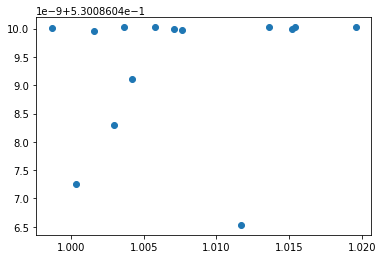

In [19]:
entropy_list = data['entropy_list'][2:-1]
correlation_list = data['correlation_list'][2:-1]
plt.plot(np.log(correlation_list), entropy_list, 'o')

In [20]:
from scipy.optimize import curve_fit

def func(xi, c, a):
    return (c / 6) * np.log(xi) + a

In [21]:
xi = correlation_list
log_xi = np.log(correlation_list)
s = entropy_list
fitParams, fitCovariances = curve_fit(func, xi, s)

In [22]:
fitCovariances

array([[ 8.96953012e-16, -1.53969115e-16],
       [-1.53969115e-16,  2.65339052e-17]])